# Create ALM NREL 5MW case
This one uses OpenFAST v4.0.2 model of the NREL5MW using ROSCO

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/projects/wind_uq/lcheung/amrwind-frontend/utilities',
                ]
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import downloadOFmodel
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil
import yaml

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

## Load the turbine model

In [3]:
downloadrecipe    = 'nrel5mw_v402_rosco.yaml'
downloadturbmodel = True                       # if True, download the turbine model from github
turbdeffile       = 'NREL5MW_v402_ROSCO.yaml'
addturbdef        = True                       # if True, add turbine model type to amr-wind-frontend turbine models

In [4]:
curdir=os.getcwd()

if downloadturbmodel:
    # Load the turbine type from the download recipe file
    with open(downloadrecipe) as f:
        yamldict = yaml.safe_load(f)
        downloadOFmodel.processModelDict(yamldict)
        
if addturbdef:
    # Load the turbine type from the download recipe file
    with open(turbdeffile) as f:
        yamldict = yaml.safe_load(f)
    
        #copy stuff over from the YAML definition
        turbinetype = case.get_default_turbinetypedict()
        for k, g in yamldict['turbines']['nre5mwFSIROSCO'].items():
            turbinetype[k] = g
            print(k+' = '+repr(g))
        
        turbinetype['turbinetype_filelocation']  = curdir
    
        # Add it to the list of turbine types
        case.add_populatefromdict('listboxturbinetype', turbinetype)

EXECUTING git clone -b v4.0.2 -n --depth=1 --filter=tree:0 git@github.com:OpenFAST/r-test.git


Cloning into 'r-test'...
X11 forwarding request failed on channel 0


EXECUTING git sparse-checkout set --no-cone glue-codes/openfast/5MW_Baseline glue-codes/openfast-cpp/5MW_Land_DLL_WTurb_cpp


X11 forwarding request failed on channel 0
X11 forwarding request failed on channel 0


GITHASH = df9ee7d
Editing NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.fst
Editing /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/setup/NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_AeroDyn.dat
Editing /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/setup/NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_ServoDyn.dat
Editing /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/setup/NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/../../openfast/5MW_Baseline/NRELOffshrBsline5MW_BeamDyn.dat
GRABFROMFILE: /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/setup/NREL5MW_v402_ROSCO/openfast/5MW_Baseline/NRELOffshrBsline5MW_BeamDyn_Blade.dat
Editing /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_li

0.0008608815426997245 DT - Recommended module time step (s) [EDITED]
         2 CompElast - Compute structural dynamics (switch) {1=ElastoDyn 2=ElastoDyn + BeamDyn for blades 3=Simplified ElastoDyn} [EDITED]
         2 CompInflow - Compute inflow wind velocities (switch) {0=still air 1=InflowWind 2=external from ExtInflow} [EDITED]
0.0215220385675 DT_Out - Time step for tabular output (s) (or "default") [EDITED]
         3 OutFileFmt - Format for tabular (time-marching) output file (switch) {1: text file [<RootName>.out] 2: binary file [<RootName>.outb] 3: both 1 and 2 4: uncompressed binary [<RootName>.outb 5: both 1 and 4} [EDITED]
         0 Wake_Mod - Wake/induction model (switch) {0=none 1=BEMT 3=OLAF} [Wake_Mod cannot be 2 or 3 when linearizing] [EDITED]
/projects/wind_uq/lcheung/amrwind-frontend/turbines/OpenFAST_NREL2p8-127_AWAKEN/libdiscon.so DLL_FileName - Name/location of the dynamic library {.dll [Windows] or .so [Linux]} in the Bladed-DLL format (-) [used only with Bladed 

## Load the precursor data

**Note**: in order to run this notebook correctly, you need access to the precursor run directory, and the setup/postprocessing files in there.

In [5]:
# Location of precursor run with boundary data
precursordir  = '/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl'
precursorsetup= precursordir+'/neutral_abl_bndry.inp'

# Location of farm run dir
farmrundir       = '../input_files'              # Put all AMR-Wind input files here 
outputfile       = 'NREL5MW_ALM_BD_OFv402.inp'   # Input file for AMR-Wind run with OpenFAST ALM turbine 
noturboutputfile = 'NREL5MW_ALM_BD_noturb.inp'   # Input file for AMR-Wind run with no turbine present
BRoutputfile     = 'NREL5MW_BR.inp'              # AMR-Wind input file for the blade-resolved run with ExaWind hybrid solver

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
#if os.path.exists(farmrundir):
#    shutil.rmtree(farmrundir)

os.makedirs(farmrundir, exist_ok = True)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('io.line_plot_int', '1'),
             ('CoriolisForcing.turn_off_vertical_force', 'True')])

In [6]:
tstart = 15000
tstop  = tstart+1000

In [7]:
OFdt = 0.0008608815426997245      # Time step for OpenFAST beamdyn

# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', OFdt*20)
case.setAMRWindInput('time.max_step',  -1)

In [8]:
# set verbosity
case.setAMRWindInput('incflo.verbose', 0)

In [9]:
# Set the restart point
chkdir = precursordir+'/chk30000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [10]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics30000.nc'
#tavg        =  [tstart, tstop]
tavg        = [15000, 16000]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo', 'ylo'] 
bndryfiles  = precursordir+'/bndry_file'

In [11]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_wf_properties=True,
                           ABLMeanBoussinesqTemperatureFile='avg_theta.dat',
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/bndry_file'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.0
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.0
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0002743665569299508, 0.0011708563286373845, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
Loading theta
SET read_temperature_profile = True
SET temperature_profile_filename = 'avg_theta.dat'
Loading u
Loading v
Loading theta
Loading hvelmag
SET wf_velocity = [6.0977889026612075, 3.6097639593035185]
SET wf_vmag = 7.103916682319445
SET wf_t

## Add the turbine

In [12]:
turbbase_xy = [[1800, 1800]]
eps         = 1.5

In [13]:
# Build the CSV input file of turbine layouts for amrwind-frontend
OFoptions=(
           # "FSTparam_CompServo:0 "
           "FSTparam_DT:0.0008608815426997245 "
           "EDparam_YawDOF:False "
           "AMRparam_Actuator_epsilon:[{eps};{eps};{eps}] "
           "AMRparam_Actuator_epsilon_tower:[{eps};{eps};{eps}] "
           "AMRparam_Actuator_openfast_stop_time:3000.0 "
          ).format(eps=eps)
#"ADparam_TwrAero:False ADparam_TwrShadow:0 ADparam_TwrPotent:0 "

turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%i, %f, %f, NREL5MW_v402_ROSCO_ALM_BD, 240.0, ,%s\n"
for iturb, xy in enumerate(turbbase_xy):
    turboptions  = OFoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
print(turbinescsv)


# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0, 1800.000000, 1800.000000, NREL5MW_v402_ROSCO_ALM_BD, 240.0, ,FSTparam_DT:0.0008608815426997245 EDparam_YawDOF:False AMRparam_Actuator_epsilon:[1.5;1.5;1.5] AMRparam_Actuator_epsilon_tower:[1.5;1.5;1.5] AMRparam_Actuator_openfast_stop_time:3000.0 



In [14]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/setup/NREL5MW_v402_ROSCO to T0_NREL5MW_v402_ROSCO
T0_NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.fst
Fixing yaw in /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/input_files/T0_NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_ElastoDyn.dat
MISMATCH between incflo.density = 1.000000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [1.5, 1.5, 1.5]
Setting Actuator_epsilon_tower to [1.5, 1.5, 1.5]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('DT', 0.0008608815426997245)])
OrderedDict([('YawDOF', 'False')])


      30.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
       1.0 AirDens - Air density (kg/m^3) [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]


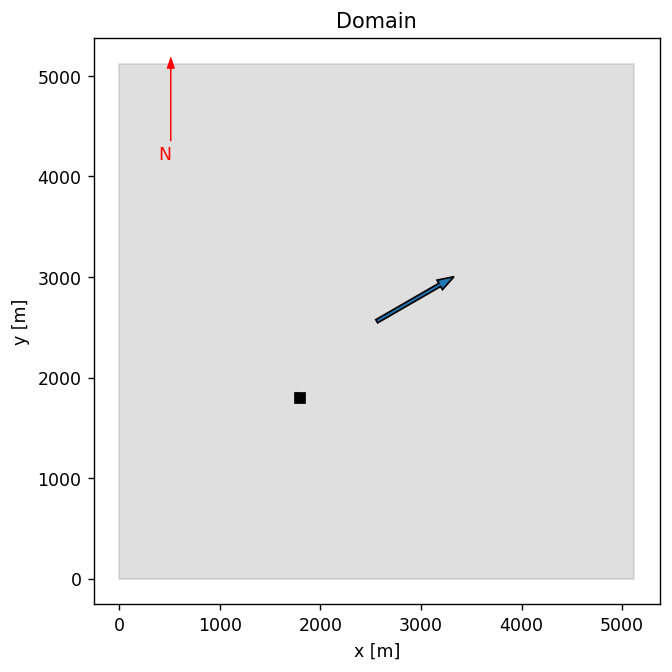

In [15]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)
for iturb, xy in enumerate(turbbase_xy):
    ax.plot(xy[0], xy[1], 'ks')

## Add refinement regions

In [16]:
## Add refinement zones
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     5,        10,         5,     0.75,   2,
1,     2.5,      5,          2,     0.75,   1.5,
2,     1.25,     2.0,        1.25,  0.75,   1.0, 
3,     0.75,     0.75,       1.00,  0.75,   0.75, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

# Uncomment this to create refinement zones
case.refine_createAllZones()

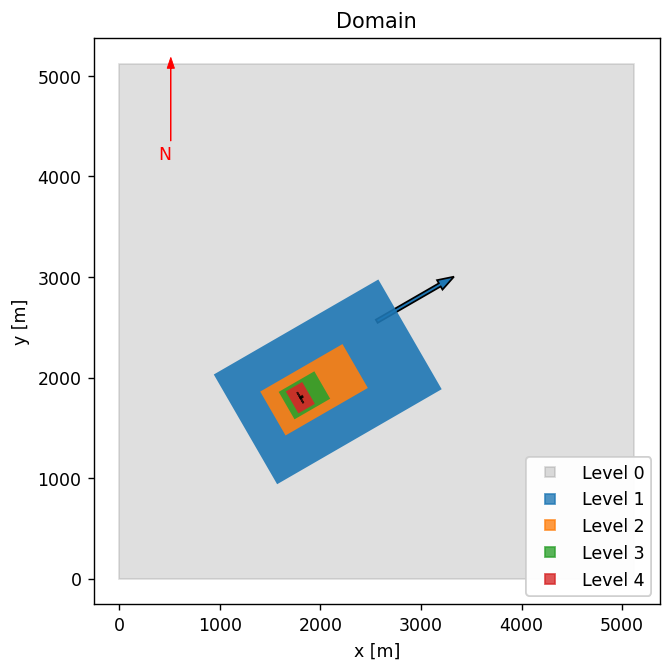

In [17]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #case.listboxpopupwindict['listboxsampling'].getitemlist() 
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.25, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

In [18]:
case.estimateMeshSize()

Refinement T0_level_0_zone: level 1: 6601240 cells
Refinement T0_level_1_zone: level 2: 8641624 cells
Refinement T0_level_2_zone: level 3: 14562737 cells
Refinement T0_level_3_zone: level 4: 36870930 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1      6601240                5.0 x 5.0 x 5.0
       2      8641624                2.5 x 2.5 x 2.5
       3     14562737             1.25 x 1.25 x 1.25
       4     36870930          0.625 x 0.625 x 0.625
  TOTAL:    117008179


## Add sampling planes

In [19]:
# First delete everything that already exists
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [20]:
## virtual metmast measurements
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
case.add_postprosetup(metmastpprosetup, verbose=True)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'virtualmast'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 20
sampledict['sampling_l_start']      = [1800, 1800, 10.0]
sampledict['sampling_l_end']        = [1800, 1800, 200.0]
case.add_sampling(sampledict, verbose=False)

postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_derived_fields: None
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [21]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:50"
samplingcsv="""
# CSV file should have columns withturbinescsv
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2,  options
rotorplaneUP,  rotorplane, 4,     0,       2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneUP_  orientation:nacdir {outputoptions} noffsets:4
rotorplaneDN,  rotorplane, 0,     10,      2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneDN_  orientation:nacdir {outputoptions} noffsets:10
nearwake,    rotorplane, 0,       2,      2,    0.7,      1,  11, 11,            usedx:0.05 outputto:nearwake_      orientation:nacdir {outputoptions} noffsets:4
turbsw,      streamwise, 4,       10,      0,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:turbsw_        orientation:nacdir {outputoptions} noffsets:0
turbhh,      hubheight,  4,       10,      2,       0,    0,   11, 11,           usedx:0.05 outputto:turbhh_        orientation:nacdir {outputoptions} noffsets:0
turb027,     hubheight,  4,       10,      2,    0.50,    0,   11, 11,           usedx:0.05 outputto:turb027_       orientation:nacdir {outputoptions} noffsets:0
turb153,     hubheight,  4,       10,      2,    -0.50,  0.50, 11, 11,           usedx:0.05 outputto:turb153_       orientation:nacdir {outputoptions} noffsets:0
turb216,     hubheight,  4,       10,      2,      -1,    1,   11, 11,           usedx:0.05 outputto:turb216_       orientation:nacdir {outputoptions} noffsets:0
sideplane1,  streamwise, 4,       10,      2,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:sideplane1_    orientation:nacdir {outputoptions} noffsets:1
sideplane2,  streamwise, 4,       10,     -2,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:sideplane2_    orientation:nacdir {outputoptions} noffsets:1
XYdomain027, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_027_ orientation:nacdir center:specified centerx:100 centery:100 centerz:27 wholedomain:1  {outputoptions} noffsets:0
XYdomain090, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_090_ orientation:nacdir center:specified centerx:100 centery:100 centerz:90 wholedomain:1  {outputoptions} noffsets:0
XYdomain153, hubheight,  8,       8,       2,       0,    153, 11, 11, units:meter usedx:10 outputto:XYdomain_153_ orientation:nacdir center:specified centerx:100 centery:100 centerz:153 wholedomain:1  {outputoptions} noffsets:0
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [22]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['virtualmast', 'T0_rotorplaneUP', 'T0_rotorplaneDN', 'T0_nearwake', 'T0_turbsw', 'T0_turbhh', 'T0_turb027', 'T0_turb153', 'T0_turb216', 'T0_sideplane1', 'T0_sideplane2', 'Farm_XYdomain027', 'Farm_XYdomain090', 'Farm_XYdomain153']


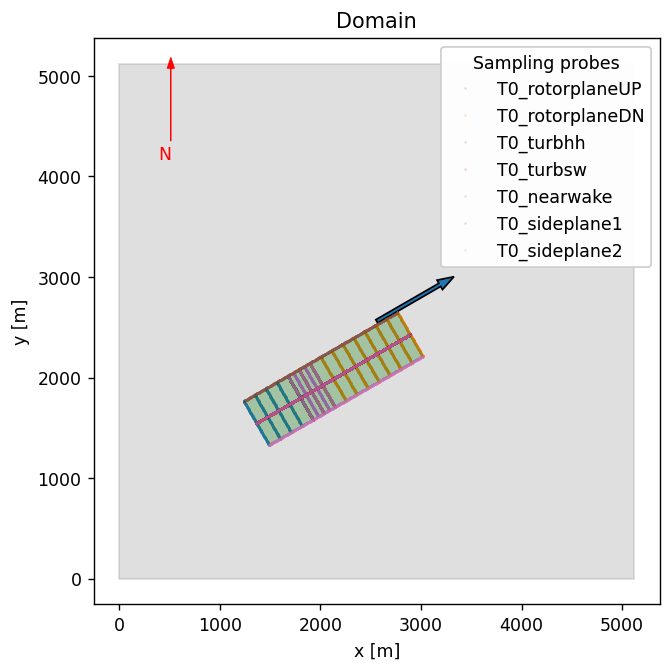

In [23]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['T0_rotorplaneUP', 'T0_rotorplaneDN', 'T0_turbhh', 'T0_turbsw','T0_nearwake',
                                                               'T0_sideplane1', 'T0_sideplane2'] #case.listboxpopupwindict['listboxsampling'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.25, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

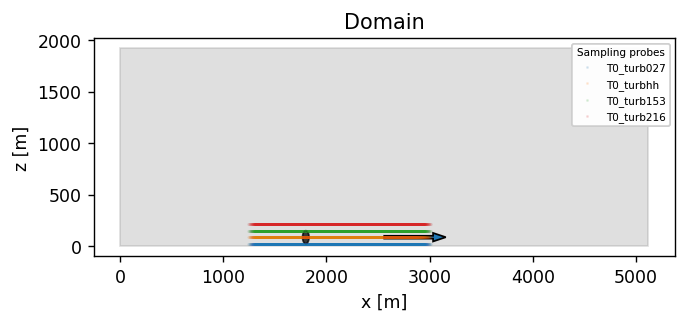

In [24]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = [] #case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [#'T0_rotorplaneUP', 'T0_rotorplaneDN', 'T0_turbhh', 'T0_turbsw','T0_nearwake',
                                                               'T0_turb027', 'T0_turbhh', 'T0_turb153','T0_turb216']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.25, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XZ'
case.popup_storteddata['plotdomain']['plot_sampleprobes_legend'] = "{'title':'Sampling probes', 'fontsize':6, 'loc':'upper right', 'markerscale':6}"
case.plotDomain(ax=ax)

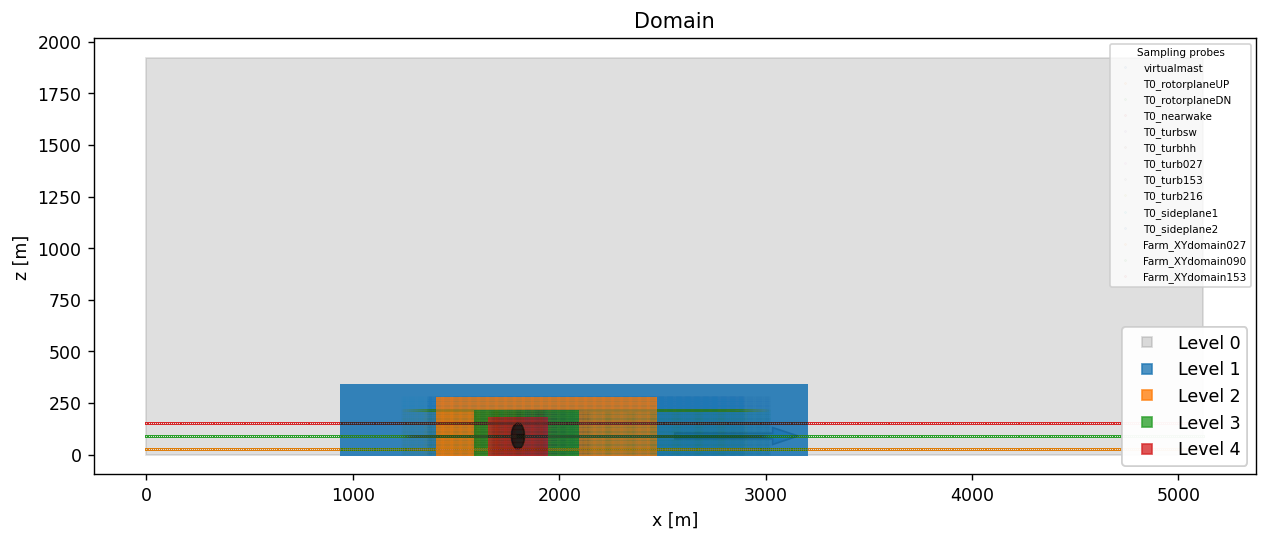

In [25]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() #['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview'] = 'XZ'
case.plotDomain(ax=ax)

In [26]:
case.validate();

-- Checking inputs --
[ PASS] max_level:           max_level = 4 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000 exists
[ PASS] boundary plane dir:  Restart directory /gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/bndry_file exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T0      [T0_NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.fst] exists
[ PASS] Actuator FST:T0      Actuator density=1.000000, matches incflo.density=1.000000
[ PASS] Actuator FST:T0      CompInflow OK
[ PASS] Actuator FST:T0      [T0_NREL5MW_v402_ROSCO/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_AeroDyn.dat] exists
[ PASS] Actuator FST:T0      WakeMod=0 OK
[ PASS] Actuator FST:T0      AirDens=1.000000, matches incflo.density=1.000000
[ PASS] Sampling probes:virtualmast is inside domain
[ PASS] Sam

In [27]:
#raise ValueError('Stop')

## Write out the input file

### For the w/turbine ALM case

In [28]:
# For the w/turbine ALM case
case.setAMRWindInput('amr.max_level',  2)
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.01721763085399449 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   

### For the without turbine ALM case

In [29]:
# For the w/o turbine ALM case
case.removeturbines()
print(case.writeAMRWindInput(noturboutputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.01721763085399449 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   

### For the blade resolved case

In [30]:
# For the blade resolved case
case.setAMRWindInput('amr.max_level',  4)
case.setAMRWindInput('time.fixed_dt',  0.003443526170799) # = OFdt*4

# These are extra parameters needed for the hybrid solver
extraparams = """
ABL.enable_hybrid_rl_mode                = true                
amr.max_grid_size                        = 128                 
amr.blocking_factor                      = 32                  
nodal_proj.max_coarsening_level          = 0                   
nodal_proj.num_pre_smooth                = 10                  
nodal_proj.num_post_smooth               = 10                  
nodal_proj.bottom_rtol                   = 1.0e-9              
nodal_proj.bottom_atol                   = 1.0e-12             
mac_proj.verbose                         = 0                   
mac_proj.max_coarsening_level            = 0                   
mac_proj.do_nsolve                       = true                
mac_proj.bottom_verbose                  = 0                   
mac_proj.bottom_rtol                     = 1.0e-11             
mac_proj.bottom_atol                     = 1.0e-12             
mac_proj.num_pre_smooth                  = 10                  
mac_proj.num_post_smooth                 = 10                  
diffusion.verbose                        = 0                   
diffusion.do_agglomeration               = false               
diffusion.do_nsolve                      = true                
velocity_diffusion.verbose               = 0                   
velocity_diffusion.use_tensor_operator   = false               
velocity_diffusion.use_segregated_operator = true                
velocity_diffusion.do_nsolve             = true                
temperature_diffusion.verbose            = 0                   
temperature_diffusion.do_nsolve          = true                
amrex.abort_on_out_of_gpu_memory         = 1                   
amrex.the_arena_is_managed               = 0                   
amrex.hypre_spgemm_use_vendor            = 1                   
amrex.hypre_spmv_use_vendor              = 0                   
amrex.hypre_sptrans_use_vendor           = 0                   
amrex.hypre_umpire_device_pool_mbs       = 4096                
hypre.bamg_verbose                       = 0                   
hypre.verbose                            = 0                   
hypre.recompute_preconditioner           = 0                   
hypre.hypre_solver                       = GMRES               
hypre.hypre_preconditioner               = BoomerAMG           
hypre.num_krylov                         = 40                  
hypre.max_iterations                     = 40                  
hypre.rtol                               = 1.e-5               
hypre.atol                               = 1.e-8               
hypre.bamg_coarsen_type                  = 8                   
hypre.bamg_interp_type                   = 6                   
hypre.bamg_relax_type                    = 11                  
hypre.bamg_num_sweeps                    = 2                   
hypre.bamg_cycle_type                    = 1                   
hypre.bamg_relax_order                   = 0                   
hypre.bamg_trunc_factor                  = 0.45                
hypre.bamg_strong_threshold              = 0.3                 
hypre.bamg_min_coarse_size               = 1                   
hypre.bamg_max_coarse_size               = 100                 
hypre.bamg_agg_num_levels                = 0                   
hypre.bamg_agg_interp_type               = 7                   
hypre.bamg_agg_pmax_elmts                = 3                   
hypre.bamg_pmax_elmts                    = 3                   
hypre.bamg_keep_transpose                = 1                   
hypre.write_matrix_files                 = 0                   
hypre.bamg_smooth_type                   = 5                   
hypre.bamg_smooth_num_sweeps             = 1                   
hypre.bamg_smooth_num_levels             = 0                   
hypre.bamg_ilu_type                      = 0                   
hypre.bamg_ilu_level                     = 0                   
hypre.bamg_ilu_max_iter                  = 1                   
hypre.bamg_ilu_reordering_type           = 0                   
hypre.bamg_ilu_tri_solve                 = 0                   
hypre.bamg_ilu_lower_jacobi_iters        = 3                   
hypre.bamg_ilu_upper_jacobi_iters        = 3                   
"""
case.loadAMRWindInput(extraparams, string=True);
print(case.writeAMRWindInput(BRoutputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.003443526170799   # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   